In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
from matplotlib.lines import Line2D

In [2]:
netflix_df = pd.read_csv("../data/raw/netflix_titles.csv")

In [ ]:
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')
netflix_df['country'] = netflix_df['country'].fillna('Unknown')
netflix_df['date_added'] = netflix_df['date_added'].fillna('Unknown')

In [4]:
netflix_df['date_added'] = netflix_df['date_added'].str.strip()

# Remove common problematic invisible characters (zero-width space, directional marks, non-breaking space)
netflix_df['date_added'] = netflix_df['date_added'].str.replace(r'[\u200b\u202a\u202c\u00a0]', '', regex=True)

# Convert to datetime
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], errors='coerce')

In [5]:
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month
netflix_df['day_added'] = netflix_df['date_added'].dt.day

In [7]:
netflix_df['year_added'] = netflix_df['year_added'].astype('Int64')
netflix_df['month_added'] = netflix_df['month_added'].astype('Int64')
netflix_df['day_added'] = netflix_df['day_added'].astype('Int64')

In [8]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      8807 non-null   object        
 4   cast          8807 non-null   object        
 5   country       8807 non-null   object        
 6   date_added    8797 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8803 non-null   object        
 9   duration      8804 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
 12  year_added    8797 non-null   Int64         
 13  month_added   8797 non-null   Int64         
 14  day_added     8797 non-null   Int64         
dtypes: Int64(3), datetime64[ns](1), int64(

<Axes: title={'center': 'Number of Titles Added per Year'}, xlabel='year_added'>

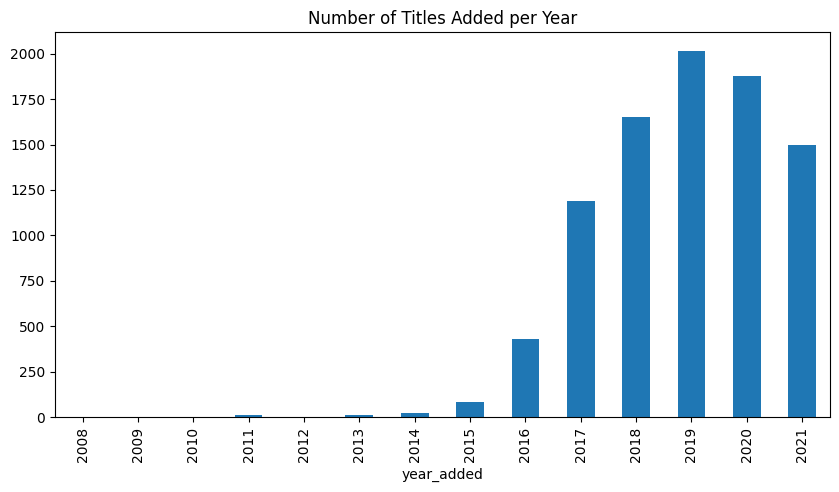

In [9]:
netflix_df['year_added'].value_counts().sort_index().plot(kind='bar', figsize=(10,5), title="Number of Titles Added per Year")

<Axes: title={'center': 'Number of Titles Added per Month'}, xlabel='month_added'>

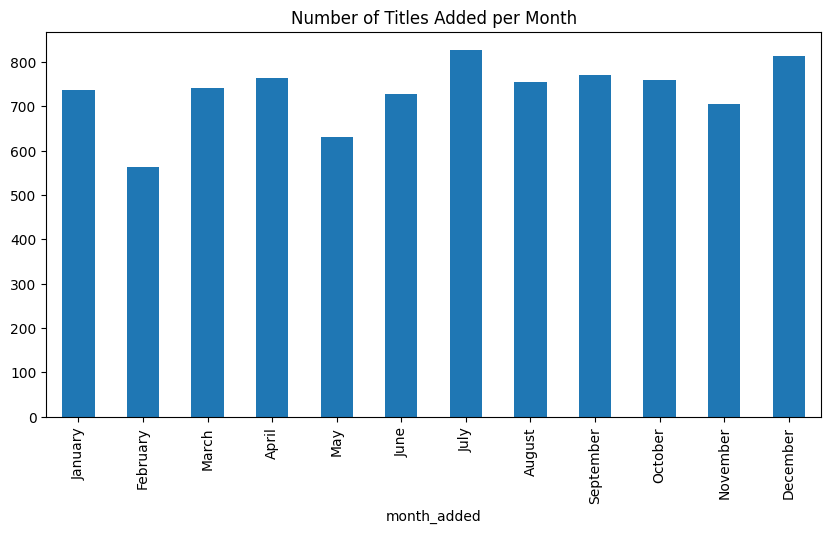

In [10]:
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Count the number of titles added per month
month_counts = netflix_df['month_added'].value_counts().sort_index()

# Map month numbers to month names
month_counts.index = month_counts.index.map(month_map)

# Plot the counts
month_counts.plot(kind='bar', figsize=(10,5), title="Number of Titles Added per Month")

<Axes: title={'center': 'Number of Titles Added per Day of Month'}, xlabel='day_added'>

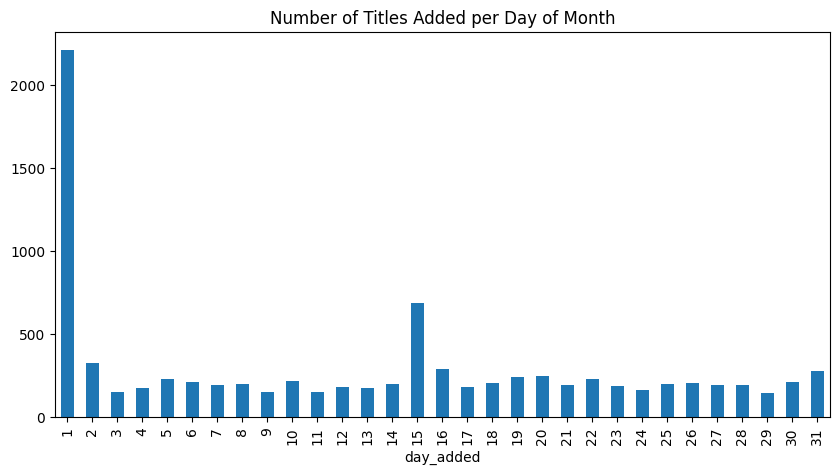

In [11]:
netflix_df['day_added'].value_counts().sort_index().plot(kind='bar', figsize=(10,5), title="Number of Titles Added per Day of Month")

<Axes: title={'center': 'Movies vs TV Shows'}, xlabel='type'>

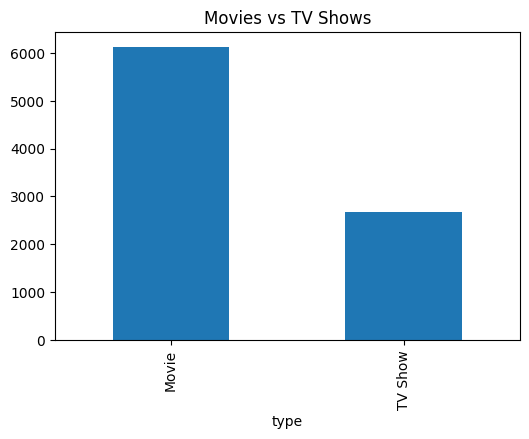

In [12]:
netflix_df['type'].value_counts().plot(kind='bar', title="Movies vs TV Shows", figsize=(6,4))


<Axes: title={'center': 'Top 10 Countries by Number of Titles'}, xlabel='country'>

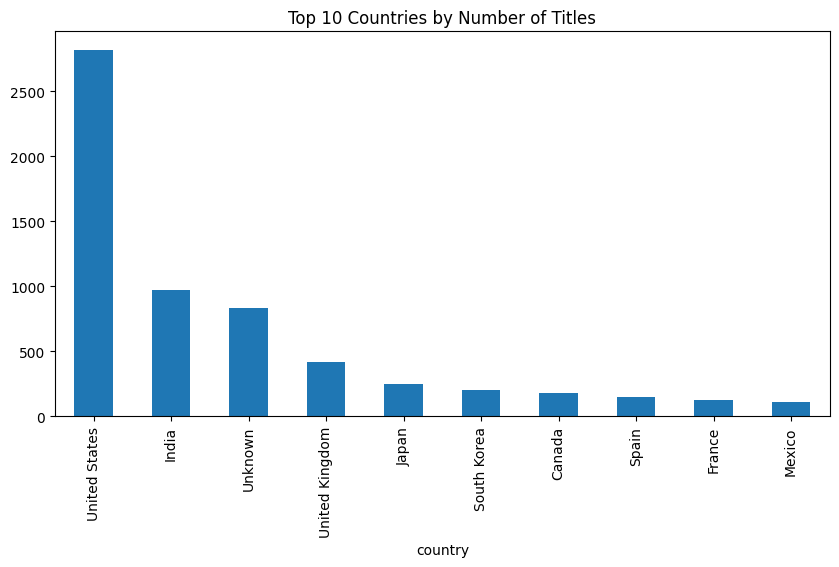

In [13]:
netflix_df['country'].value_counts().head(10).plot(kind='bar', title="Top 10 Countries by Number of Titles", figsize=(10,5))


<Axes: title={'center': 'Top 10 Netflix Genres'}, ylabel='Genre'>

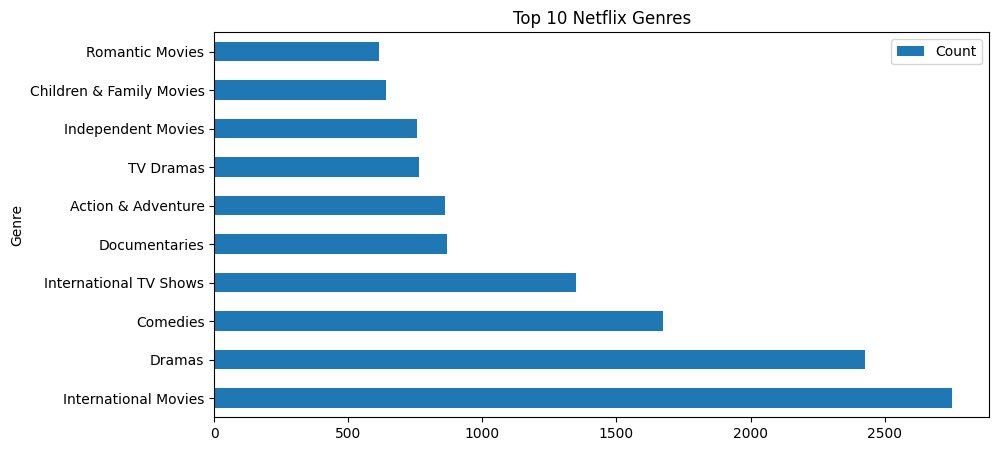

In [ ]:

genres = ','.join(netflix_df['listed_in']).split(',')
genres = [g.strip() for g in genres]
genre_counts = Counter(genres)


genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)
genre_df.head(10).plot(kind='barh', x='Genre', y='Count', title="Top 10 Netflix Genres", figsize=(10,5))


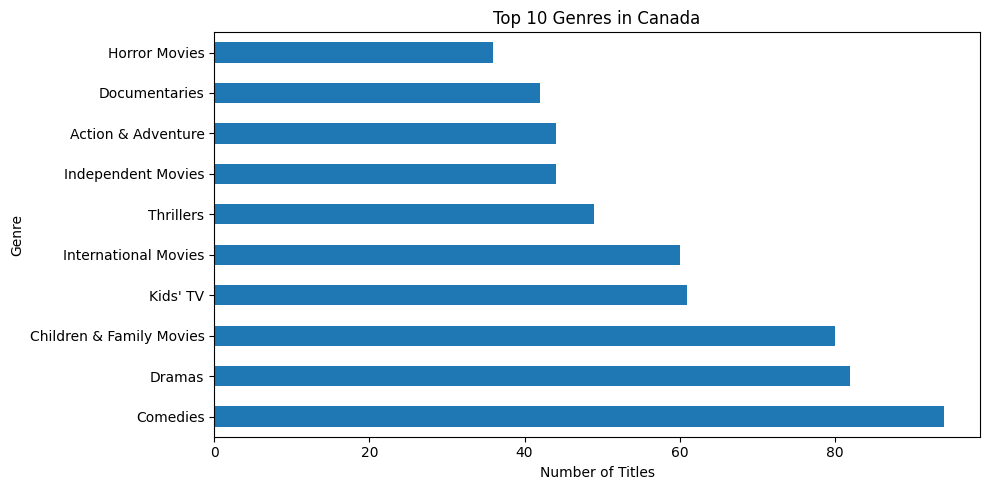

In [17]:
# Explode genres
netflix_df['genre_split'] = netflix_df['listed_in'].str.split(', ')
df_genre = netflix_df.explode('genre_split')

# Explode countries
df_genre['country_split'] = df_genre['country'].str.split(', ')
df_genre = df_genre.explode('country_split')

# Group by country + genre
country_genre_counts = df_genre.groupby(['country_split', 'genre_split']).size().reset_index(name='count')

# Filter for a specific country
top_country = 'Canada'
df_top = country_genre_counts[country_genre_counts['country_split'] == top_country].sort_values(by='count', ascending=False).head(10)

# Plot
ax = df_top.plot(
    kind='barh',
    x='genre_split',
    y='count',
    figsize=(10,5),
    title=f"Top 10 Genres in {top_country}",
    legend=False
)
ax.set_xlabel("Number of Titles")
ax.set_ylabel("Genre")
plt.tight_layout()
plt.show()


In [18]:
netflix_df[['duration_int', 'duration_unit']] = netflix_df['duration'].str.extract(r'(\d+)\s*(\w+)')
netflix_df['duration_int'] = netflix_df['duration_int'].astype(float)


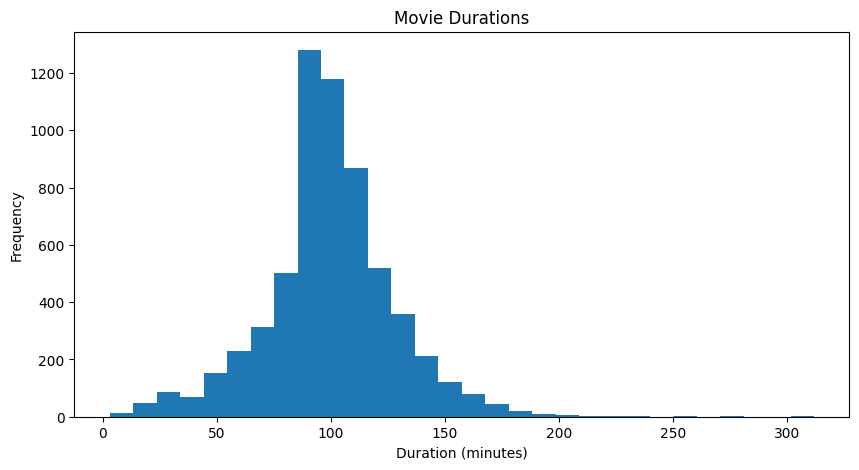

In [19]:
ax = netflix_df[netflix_df['duration_unit']=='min']['duration_int'].plot(
    kind='hist', bins=30, title="Movie Durations", figsize=(10,5)
)

ax.set_xlabel("Duration (minutes)")
ax.set_ylabel("Frequency")

plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_5976\3994092003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['duration_int'] = tv_shows['duration'].str.extract(r'(\d+)').astype(int)


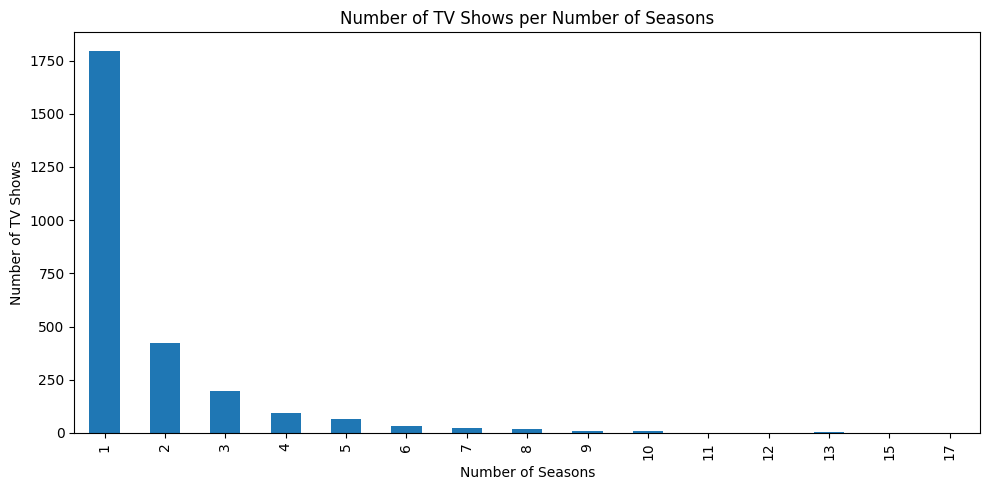

In [20]:

tv_shows = netflix_df[netflix_df['type'] == 'TV Show']

# Uisti sa, že duration_int je správne
tv_shows['duration_int'] = tv_shows['duration'].str.extract(r'(\d+)').astype(int)

# Bar plot počtu seriálov podľa počtu sezón
season_counts = tv_shows['duration_int'].value_counts().sort_index()

ax = season_counts.plot(
    kind='bar',
    figsize=(10, 5),
    title='Number of TV Shows per Number of Seasons'
)
ax.set_xlabel('Number of Seasons')
ax.set_ylabel('Number of TV Shows')


plt.tight_layout()
plt.show()


Top 10 central countries (by collaboration):
United States: 0.7797
United Kingdom: 0.5508
Germany: 0.4915
France: 0.4831
Canada: 0.3390
South Africa: 0.2712
Italy: 0.2627
Belgium: 0.2627
India: 0.2542
Denmark: 0.2458


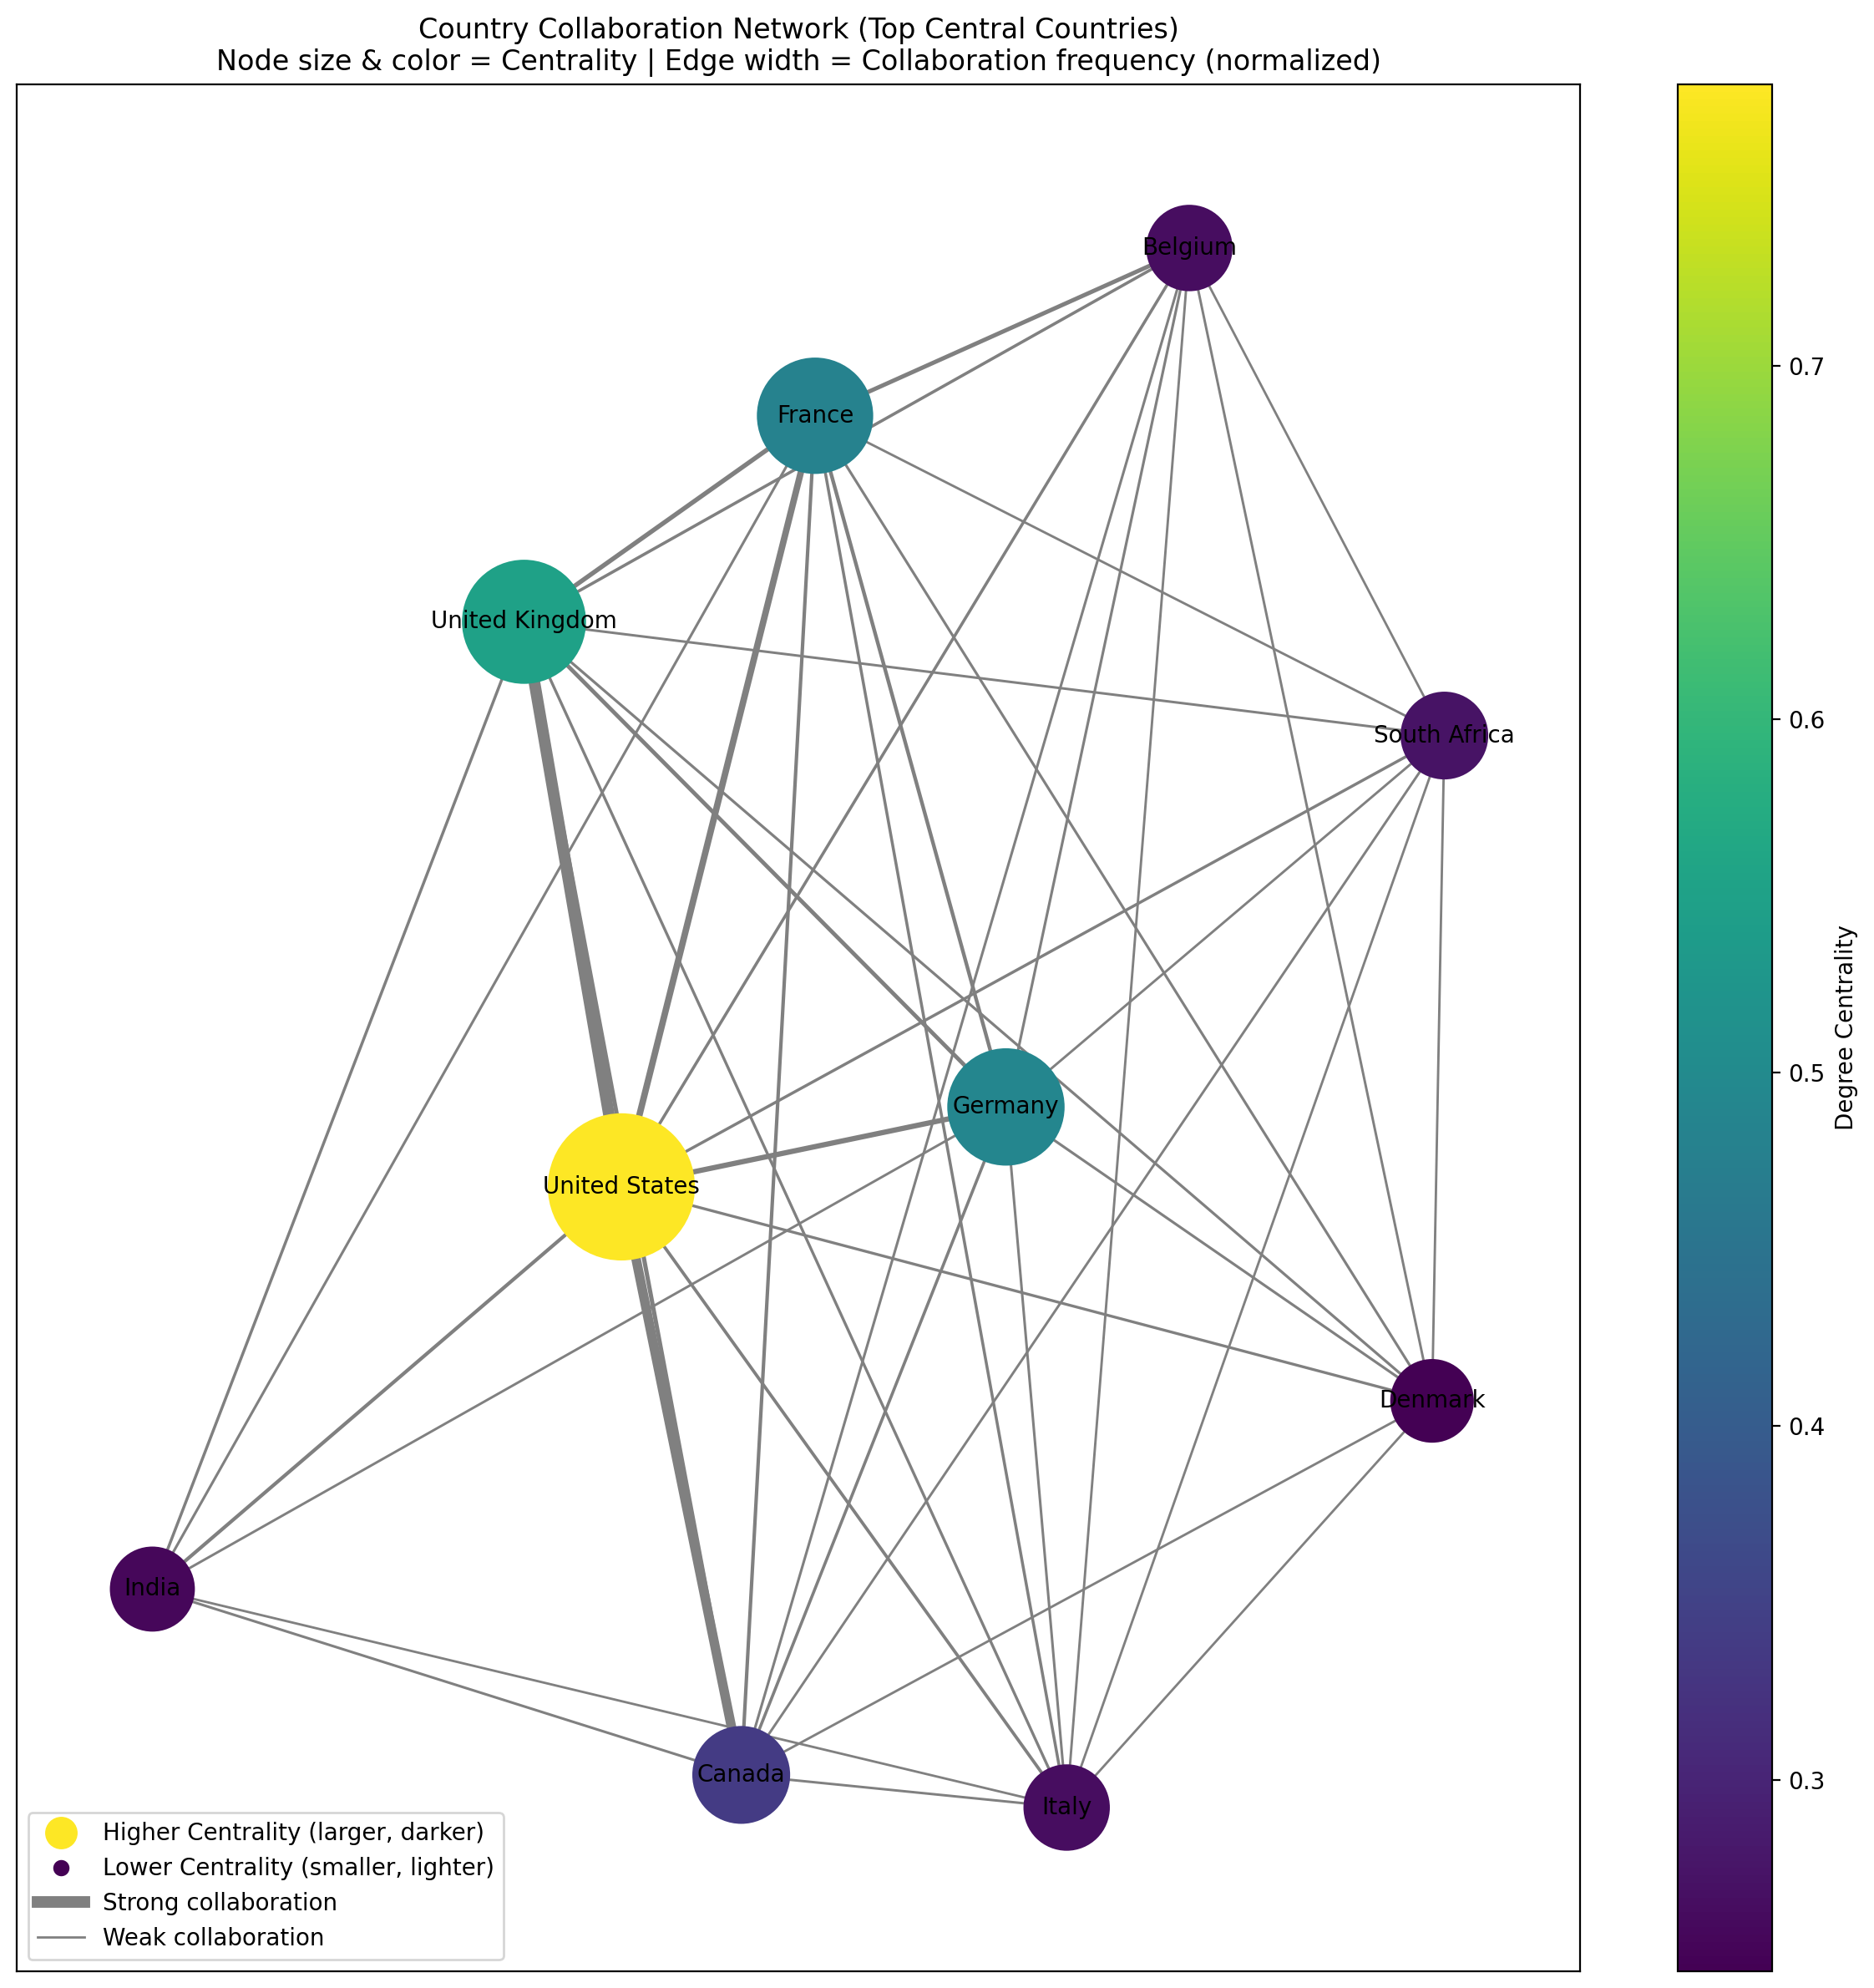

In [24]:
# Príprava dát
df_country = netflix_df.dropna(subset=['country']).copy()
df_country['country_list'] = df_country['country'].str.split(', ')

# Graf + počítanie spoluprác
G_c = nx.Graph()
edge_counter = Counter()

for countries in df_country['country_list']:
    if len(countries) > 1:
        for i in range(len(countries)):
            for j in range(i + 1, len(countries)):
                edge = tuple(sorted([countries[i], countries[j]]))
                G_c.add_edge(*edge)
                edge_counter[edge] += 1

# Degree centrality
centrality_c = nx.degree_centrality(G_c)

# Top centrálne krajiny
top_central_c = sorted(centrality_c.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 central countries (by collaboration):")
for country, cent in top_central_c:
    print(f"{country}: {cent:.4f}")

# Podgraf
top_nodes_c = [node for node, _ in top_central_c]
H_c = G_c.subgraph(top_nodes_c)

# Veľkosť, farba, hrúbka hrán
sizes = [5000 * centrality_c.get(node, 0.001) for node in H_c.nodes()]
colors = [centrality_c.get(node, 0.001) for node in H_c.nodes()]
weights = [edge_counter.get(tuple(sorted(edge)), 1) for edge in H_c.edges()]
max_weight = max(weights)
norm_weights = [1 + 4 * (w / max_weight) for w in weights]

# Vizualizácia
plt.figure(figsize=(12, 12), dpi=200)
pos = nx.spring_layout(H_c, k=0.5, seed=42)

nodes = nx.draw_networkx_nodes(
    H_c, pos,
    node_size=sizes,
    node_color=colors,
    cmap=plt.cm.viridis
)
nx.draw_networkx_edges(
    H_c, pos,
    width=norm_weights,
    edge_color='gray'
)
nx.draw_networkx_labels(H_c, pos, font_size=10)

plt.title("Country Collaboration Network (Top Central Countries)\nNode size & color = Centrality | Edge width = Collaboration frequency (normalized)")

# Colorbar pre uzly
cbar = plt.colorbar(nodes, label='Degree Centrality')

# Vlastná legenda
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Higher Centrality (larger, darker)',
           markerfacecolor=plt.cm.viridis(1.0), markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Lower Centrality (smaller, lighter)',
           markerfacecolor=plt.cm.viridis(0.0), markersize=8),
    Line2D([0], [0], color='gray', lw=5, label='Strong collaboration'),
    Line2D([0], [0], color='gray', lw=1, label='Weak collaboration')
]
plt.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
# plt.savefig("country_collaboration_network_with_legend_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


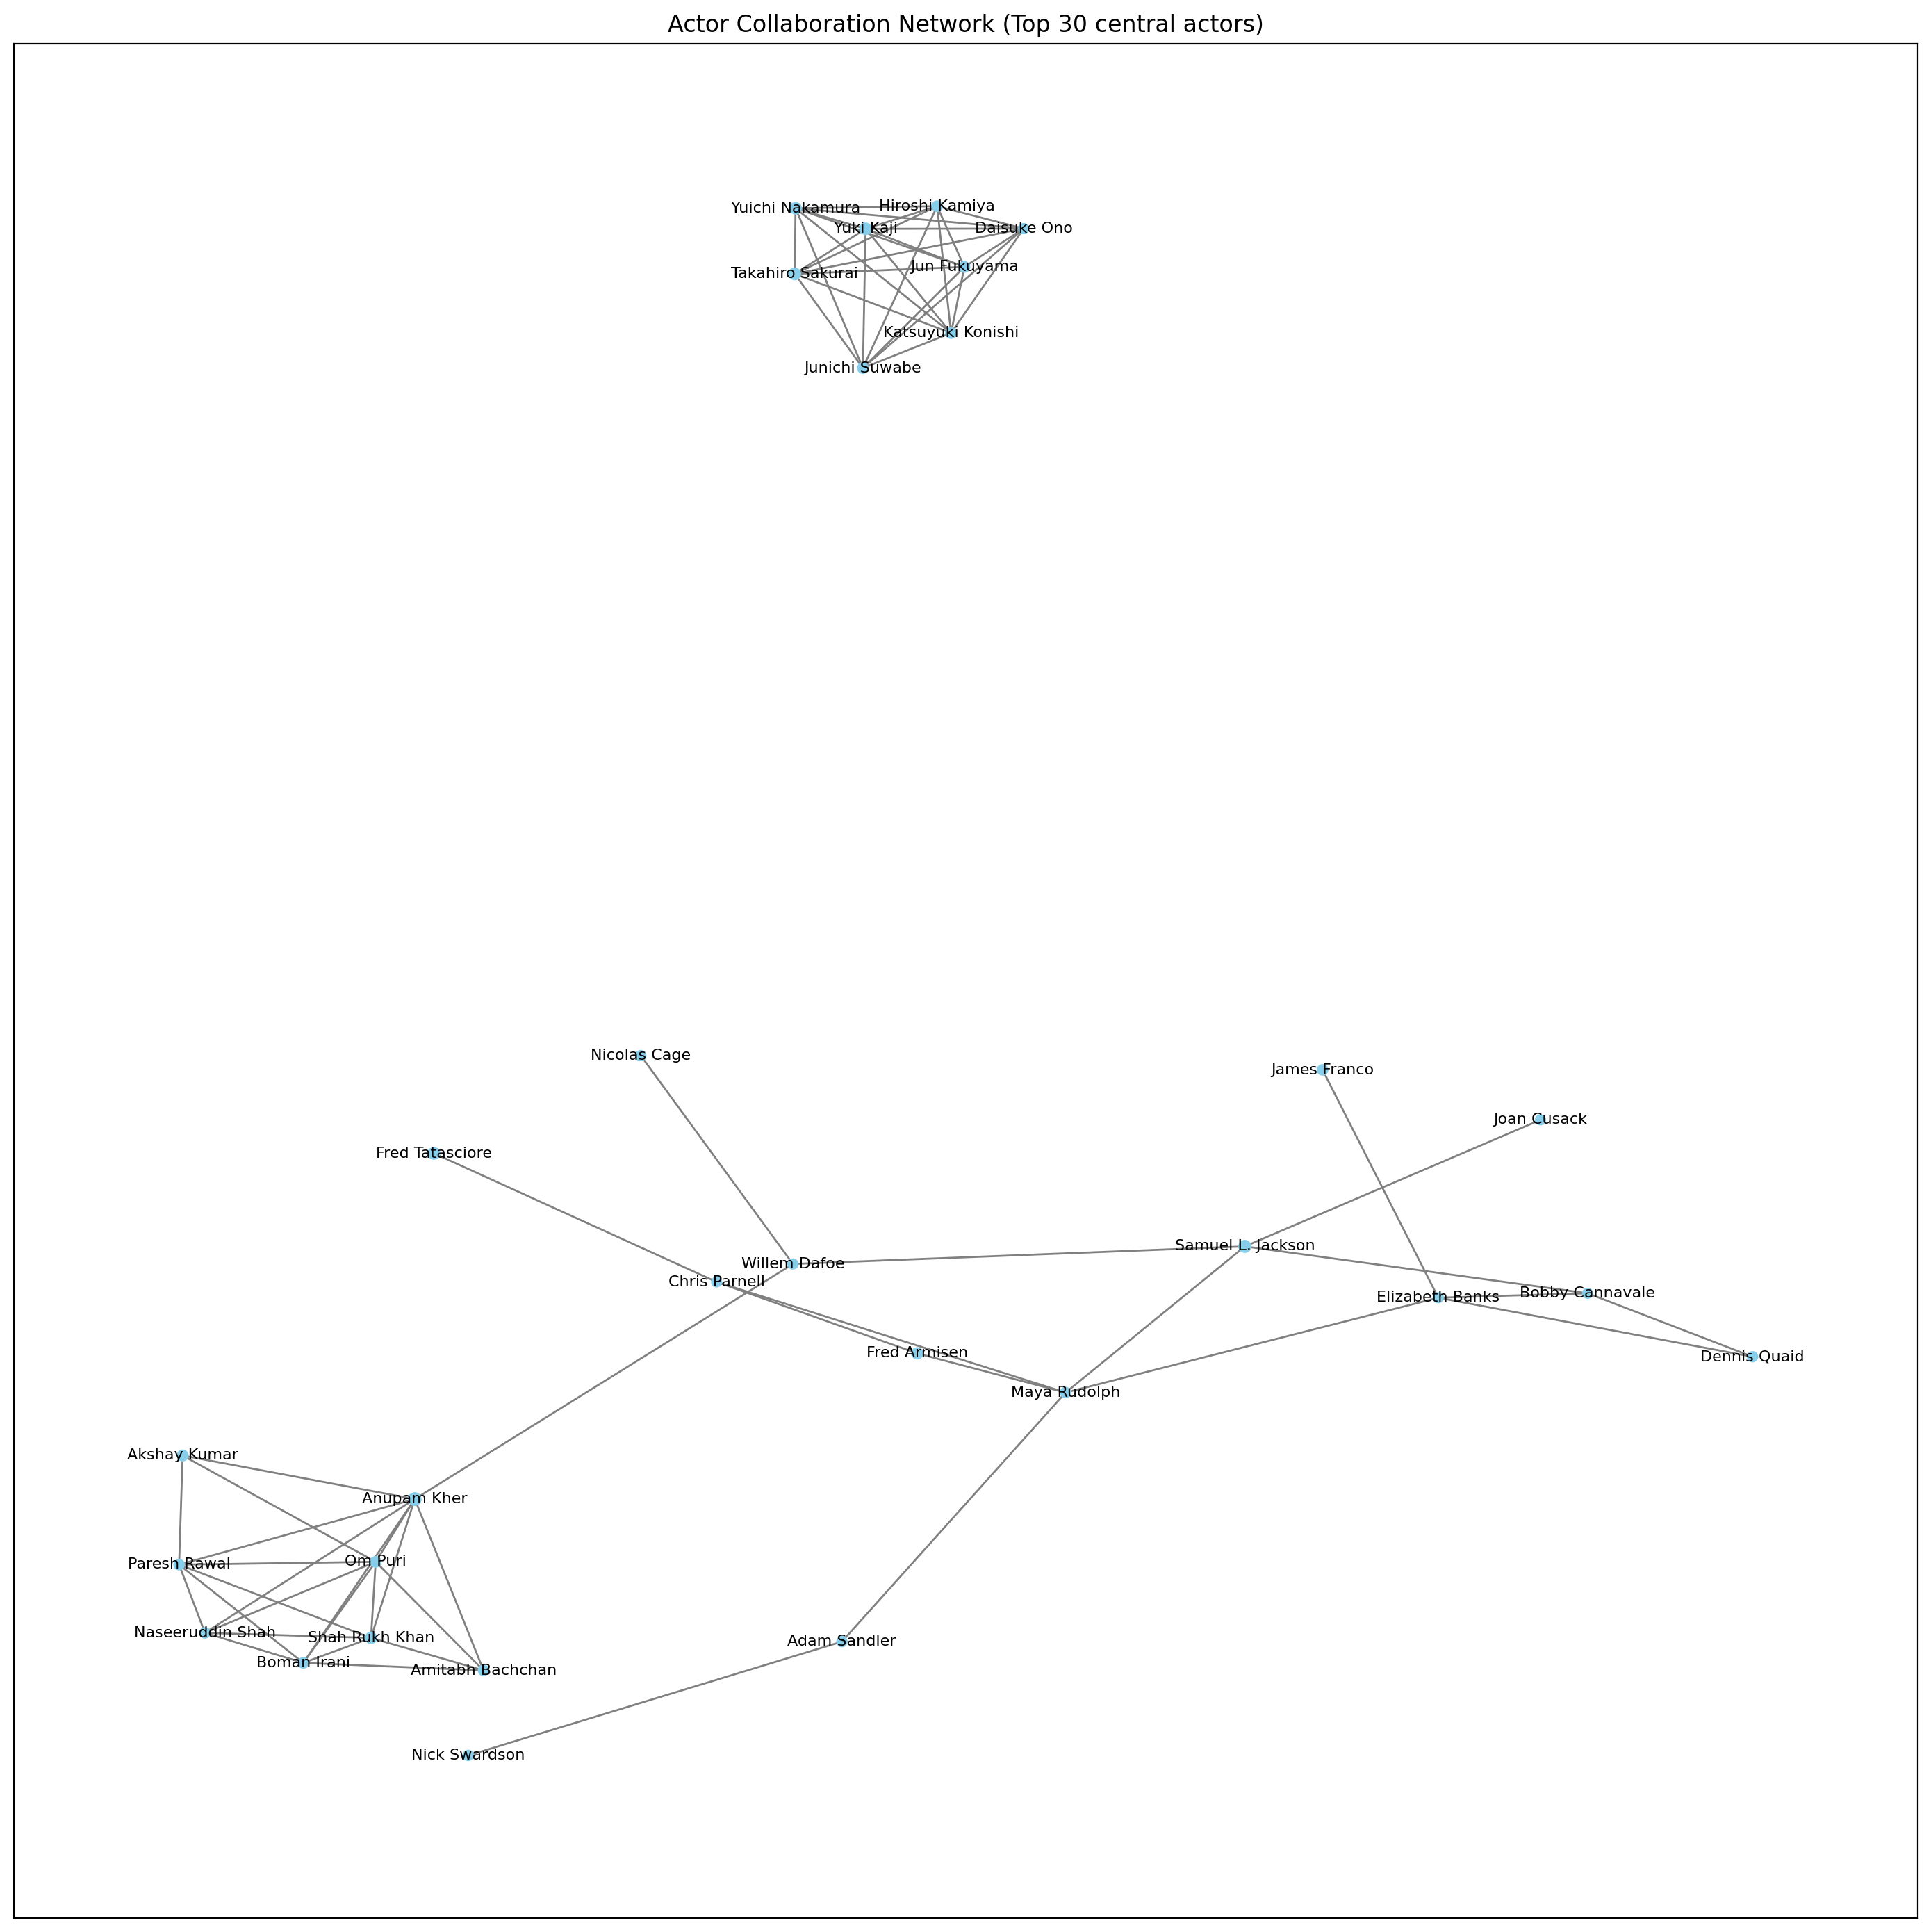

In [25]:
# Vyber len riadky s obsadením
df_cast = netflix_df.dropna(subset=['cast']).copy()

# Rozbi na zoznam hercov
df_cast['cast_list'] = df_cast['cast'].str.split(', ')

# Inicializácia grafu
G = nx.Graph()

# Pridaj hrany: každý pár hercov v rovnakom titule
for cast in df_cast['cast_list']:
    if len(cast) > 1:
        for i in range(len(cast)):
            for j in range(i + 1, len(cast)):
                G.add_edge(cast[i], cast[j])

# Degree centrality
centrality = nx.degree_centrality(G)

# Najcentrálnejší herci
top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:20]

# Vyber podgraf okolo top 50 hercov
top_nodes = [node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:30]]
H = G.subgraph(top_nodes)

# Vizualizácia
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 14), dpi=200)

# Stabilné a lepšie rozmiestnenie uzlov
pos = nx.spring_layout(H, k=0.4, seed=42)

# Veľkosť uzlov podľa centrality
sizes = [5000 * centrality.get(node, 0.001) for node in H.nodes()]

# Kresli sieť
nx.draw_networkx(
    H, pos,
    with_labels=True,
    node_size=sizes,
    font_size=8,
    edge_color='gray',
    node_color='skyblue'
)

plt.title("Actor Collaboration Network (Top 30 central actors)")
plt.tight_layout()
plt.show()
